# Human In the Loop

之前我们学习了如何创建、观察和控制团队；这里重点讲如何从你的应用程序与团队交互，给 Team 提供人类反馈，让 AI 系统更灵活、智能。

本节将主要介绍，在使用 Autogen 构架的 AI 应用中有两种主要与 Team 进行交互的方式：

1. Team 运行过程中（ `run()` 或 `run_stream()` 执行时）
    - 通过一个特殊的 `UserProxyAgent`，允许人类直接插入反馈消息；
    - 这样团队在运行时能实时接收和利用人类输入，调整对话方向或结果。

2. Team 运行结束后
    - 通过下一次调用 `run()` 或 `run_stream()` 时传入的输入，继续向团队提供反馈；
    - 这种方式适合分阶段任务或多轮循环，对话之间有人类主动参与。


In [1]:
import os
from dotenv import load_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient

load_dotenv()
siliconflow_api_key = os.getenv("SILICONFLOW_API_KEY") # 读取你的 OPENAI API key

# 初始化 OpenAIChatCompletionClient 客户端，连接到硅基流动平台的 Qwen3-8B 模型
model_client = OpenAIChatCompletionClient(
    model="Qwen/Qwen3-8B",                # 指定要调用的模型名称，硅基流动平台上 Qwen 3-8B 模型
    base_url="https://api.siliconflow.cn/v1",  # 硅基流动平台的 API 访问地址
    api_key=siliconflow_api_key,  # 你的 API 密钥
    model_info={                        
        "family": "qwen",              
        "context_length": 8192,        
        "max_output_tokens": 2048,     
        "tool_choice_supported": True, 
        "tool_choice_required": False,  
        "structured_output": True,     
        "vision": False,                
        "function_calling": True,      
        "json_output": True           
    },
)

## 两种交互方式

| 交互时机 | 交互方式           | 适用场景           |
| ---- | -------------- | -------------- |
| 运行中  | UserProxyAgent | 实时人类反馈，调整生成内容  |
| 运行后  | 下一次输入          | 分阶段多轮任务，人类主动参与 |


### Providing Feedback During a Run

在 Team 运行中进行实时的人机交互，我们需要用到 `UserProxyAgent`， 这是一个 Autogen 内置的 Agent，用于代表用户向 Team提供反馈。要使用 `UserProxyAgent`，你可以先创建一个其实例，并在运行 Team 之前将其加入到 Team 中。Team 会根据运行过程中的需要决定何时调用 `UserProxyAgent`，以向用户请求反馈。

例如，在 `RoundRobinGroupChat` Team 中，`UserProxyAgent` 会按照其传入团队时的顺序被调用；而在 `SelectorGroupChat`（选择式小组对话）团队中，是否调用 `UserProxyAgent` 则由选择器提示词（`selector prompt`）或选择函数（`selector function`）来决定。

> 详细的关于 `UserProxyAgent` 的讲解 参考 [2-Agent](./2-Agent.ipynb)

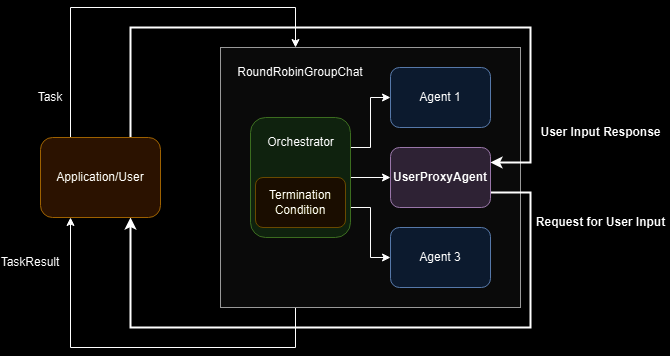

加粗的箭头表示 Team 运行过程中的控制流程：当团队调用 UserProxyAgent 时，控制权会从团队转移到应用程序或用户，团队暂停运行并等待用户反馈；一旦用户提供了反馈，控制权再度转回团队，团队继续执行后续任务。


当在 Team 运行过程中调用 `UserProxyAgent` 时，Team 的执行将被**阻塞**，直到用户提供反馈或发生错误为止。这种阻塞行为会**暂停 Team 的进程**，并使 Team 处于一个**无法保存或恢复的非稳定状态**。

由于该方法具有阻塞性质，建议**仅在需要用户立即反馈的短时交互场景中使用**，例如：通过按钮点击请求用户批准或拒绝，或弹出警告提示用户必须立即处理，否则任务将失败。


以下是一个示例，展示了如何在 `RoundRobinGroupChat` 中使用 `UserProxyAgent` 来完成诗歌生成任务，当用户输入 `APPROVE` 时停止 Team 任务：

In [2]:
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# 创建智能体
model_client = model_client  # 使用上面初始化的模型客户端
assistant = AssistantAgent("assistant", model_client=model_client)
user_proxy = UserProxyAgent("user_proxy", input_func=input)  # 使用 input() 从控制台获取用户输入

# 创建终止条件：当用户回复 "APPROVE" 时结束对话
termination = TextMentionTermination("APPROVE")

# 创建团队
team = RoundRobinGroupChat([assistant, user_proxy], termination_condition=termination)

# 运行团队对话，并将消息流输出到控制台
stream = team.run_stream(task="Write a 4-line poem about the ocean.")
# 在脚本中建议用 asyncio.run(...) 启动
await Console(stream)
await model_client.close()

---------- TextMessage (user) ----------
Write a 4-line poem about the ocean.
---------- ThoughtEvent (assistant) ----------

The user asked me to write a 4-line poem about the ocean. They're probably looking for something creative and simple, maybe for fun or inspiration. I should keep my response brief and to the point, building on the tools I'm designed to use.
I don't have specific tools for generating poetry, but I can draw on my general knowledge to create a quick, evocative poem. I'll focus on common themes like vastness, movement, and beauty to make it engaging.
Now, let's craft the poem. First line: Start with the ocean's size and mystery. Second line: Whisper its secrets—adds drama. Third line: Describe its motion—waves rising and falling. Fourth line: End with a payoff—showing how small we are in comparison.
This covers the key elements: infinity, secrets, waves, and human scale. It should fulfill the user's request while being concise.
Finally, remember to end with 'TERMINA

Enter your response:  continue


---------- TextMessage (user_proxy) ----------
continue
---------- ThoughtEvent (assistant) ----------

Okay, the user's query is simply "continue." They want me to continue, but where? Looking at the previous interaction, the user asked for a poem about the ocean, and the assistant responded with four lines. Then the user said "continue," so maybe they wanted more verses or to expand on the existing one.

First, I need to understand the context. The original poem had four lines. The user might expect another four lines, making it a two-part structure. Alternatively, they might want a continuation in the story or theme, but since the assistant's response was a poem, it's likely they want the same format.

The user's identity could be someone interested in poetry, looking for creative writing assistance. They might be a student, a writer, or just someone exploring their creative side. Their actual need is to get more content in the form of a poem. But what's the deeper need? Maybe they'

Enter your response:  APPROVE


---------- TextMessage (user_proxy) ----------
APPROVE


---------- ThoughtEvent (assistant) ----------

Hmm, the user asked me to write a 4-line poem about the ocean. That seems straightforward. Let me think about how to approach this.

First, I need a poem that captures the ocean's essence in just four lines. It should be concise but evocative. I could focus on one aspect - maybe its mystery, power, or beauty. The ocean is a vast subject with many dimensions.

The first line should establish the ocean's presence strongly. Then I'll build on that with imagery in the second line. The third line might contrast its beauty with danger, and the fourth could conclude with wonder. That would create nice range in such a short piece.

Since I'm an AI assistant, I should make sure my response demonstrates good poetic skills while staying simple enough for a general audience to appreciate. Nature themes often resonate well.

I'll choose iambic meter for rhythm - it's natural for poetry and works well for these short lines. The rhyme scheme shouldn't b

从控制台输出可以看到，团队通过 `user_proxy` 向用户请求反馈，以确认生成的诗歌是否被接受。

你还可以为 `UserProxyAgent` 提供自定义的输入函数，从而**定制反馈流程**。例如，当团队作为一个 Web 服务运行时，可以使用自定义的输入函数等待来自 WebSocket 连接的消息。


### Providing Feedback to the Next Run

在很多应用场景中，用户或程序是一边看结果、一边给反馈，再继续运行 Team，就像一个“你问我答、我再调整”的互动循环。

这个过程一般是这样：

1. 团队先运行一轮，比如写一首诗；

2. 用户看完结果，说“我不太喜欢，再文艺点”；

3. 团队接收到这个反馈，再次运行，生成新的版本。

这个方法特别适合那种对话内容要保存下来、用户不一定立刻回复的情况，比如：

- 在网页或 App 里和 AI 团队对话；

- 用户可能关掉页面或稍后再回来回复；

- 团队会话状态会被“存起来”，等用户反馈来了再“接着上次的继续跑”。

可以理解成：🗂️ 一次聊天 → 🛑 等你反馈 → 💾 把进度保存 → 🕐 你回来 → 🔁 继续上次对话

> 关于如何保存和加载团队的状态，请参考 “Managing State（状态管理）” 章节。本节将重点介绍反馈机制的具体使用方式。

下图展示了在这种交互式流程中，控制权的流转方式：


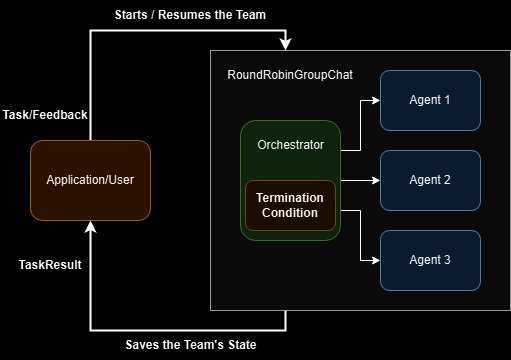


有两种方式可以实现这种交互流程：

1. 设置最大轮数，让团队在执行指定轮数后自动停止；

2. 使用诸如 `TextMentionTermination` 和 `HandoffTermination` 等终止条件，让团队根据自身的内部状态判断何时停止并将控制权交还。

你也可以将这两种方式结合使用，以实现你期望的控制行为。

#### Using Max Truns 设置最大轮数

这种方法允许你通过设置最大轮数来暂停团队运行，以等待用户输入。
比如，将 max_turns 设置为 1，就能让团队在第一个 Agent 回复之后自动停止。
这在需要用户持续参与的场景（例如聊天机器人）中尤其有用。

你只需在创建 RoundRobinGroupChat 时设置 max_turns 参数即可

- 每当团队运行停止时，轮数计数器会被重置；

- 当你再次运行团队时，从轮数 0 开始；

- 但团队的内部状态（如对话上下文、当前轮到哪个 agent）会被保留；

> 例如：RoundRobinGroupChat 会从上次停止时的下一个 agent 继续执行。

注意事项：

max_turns 是团队类的特有参数，目前只支持以下团队类型：

- RoundRobinGroupChat

- SelectorGroupChat

- Swarm

当 max_turns 与其他终止条件（如 TextMentionTermination）一起使用时，只要任一条件满足，团队就会停止。

下面的示例为：限制团队运行 1 轮用于诗歌生成

In [4]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# 创建智能体
model_client = model_client  # 使用上面初始化的模型客户端
assistant = AssistantAgent("assistant", model_client=model_client)

# 创建团队，设置最大轮数为1
team = RoundRobinGroupChat([assistant], max_turns=1)

task = "Write a 4-line poem about the ocean."
while True:
    # 运行团队对话，并将消息流输出到控制台
    stream = team.run_stream(task=task)
    # 在脚本中建议用 asyncio.run(...) 启动
    await Console(stream)
    # 获取用户反馈
    task = input("请输入你的反馈（输入 'exit' 退出）：")
    if task.lower().strip() == "exit":
        break
await model_client.close()

---------- TextMessage (user) ----------
Write a 4-line poem about the ocean.
---------- ThoughtEvent (assistant) ----------

First, the user asked me to write a 4-line poem about the ocean. That sounds straightforward, like a creative task that might be for fun or inspiration. I'm an AI assistant, so this fits well within my capabilities—I can generate poetry easily. 

Now, let's think about the user. They might be a student working on a writing assignment, a poet looking for inspiration, or someone dealing with ocean-related thoughts, like a beach vacation memory. The query is simple, but there could be deeper needs here. For example, they might be seeking emotional comfort from nature's vastness, a sense of tranquility, or even a spark for their own creativity. I should aim to make the response engaging and positive to address that.

I need to ensure the poem has exactly four lines. Something short and rhythmic would work best. I'll focus on key elements of the ocean—like its sound,

请输入你的反馈（输入 'exit' 退出）： exit


你可以看到，团队在**第一个智能体回复后立即停止**运行，这正是因为我们设置了 `max_turns=1`，限制了团队本轮只运行一轮。


#### Using Termination Conditions 设置终止条件

在前面的部分中，我们已经见过多种终止条件的使用示例。
本节重点介绍其中的一种特殊终止方式：`HandoffTermination`。
它会在团队中某个智能体发送 `HandoffMessage` 消息时使团队停止运行。

当一个智能体在执行任务过程中发现自己无法继续处理（例如缺少工具），
它可以选择“交接控制权”（发送 HandoffMessage），
此时 HandoffTermination 会触发，让团队暂停，等待人类或其他 agent 接手。


下面这段代码展示了如何使用 `HandoffTermination` 和 `TextMentionTermination` 实现一个“遇事就交接”的懒惰助手团队。下面是详细的中文注释和讲解：

In [2]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.base import Handoff
from autogen_agentchat.conditions import HandoffTermination, TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# 创建 OpenAI 模型客户端
model_client = model_client

# 创建一个“懒惰”助手智能体，遇到无法完成的任务就 handoff 给 user
lazy_agent = AssistantAgent(
    "lazy_assistant",
    model_client=model_client,
    handoffs=[Handoff(target="user", message="Transfer to user.")],
    system_message="If you cannot complete the task, transfer to user. Otherwise, when finished, respond with 'TERMINATE'.",
)

# 定义 handoff 终止条件
handoff_termination = HandoffTermination(target="user")
# 定义文本终止条件
text_termination = TextMentionTermination("TERMINATE")

# 创建只包含 lazy_assistant 的团队，终止条件为 handoff 或 TERMINATE
lazy_agent_team = RoundRobinGroupChat([lazy_agent], termination_condition=handoff_termination | text_termination)

# 运行团队任务并输出到控制台
task = "What is the weather in New York?"
await Console(lazy_agent_team.run_stream(task=task), output_stats=True)

---------- TextMessage (user) ----------
What is the weather in New York?
---------- ThoughtEvent (lazy_assistant) ----------



---------- ToolCallRequestEvent (lazy_assistant) ----------
[FunctionCall(id='0197bf304d7f0a204e261955719f83ab', arguments=' {}', name='transfer_to_user')]
[Prompt tokens: 175, Completion tokens: 663]
---------- ToolCallExecutionEvent (lazy_assistant) ----------
[FunctionExecutionResult(content='Transfer to user.', name='transfer_to_user', call_id='0197bf304d7f0a204e261955719f83ab', is_error=False)]
---------- HandoffMessage (lazy_assistant) ----------
Transfer to user.
---------- Summary ----------
Number of messages: 5
Finish reason: Handoff to user from lazy_assistant detected.
Total prompt tokens: 175
Total completion tokens: 663
Duration: 13.01 seconds


TaskResult(messages=[TextMessage(source='user', models_usage=None, metadata={}, content='What is the weather in New York?', type='TextMessage'), ThoughtEvent(source='lazy_assistant', models_usage=None, metadata={}, content='\n\n', type='ThoughtEvent'), ToolCallRequestEvent(source='lazy_assistant', models_usage=RequestUsage(prompt_tokens=175, completion_tokens=663), metadata={}, content=[FunctionCall(id='0197bf304d7f0a204e261955719f83ab', arguments=' {}', name='transfer_to_user')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='lazy_assistant', models_usage=None, metadata={}, content=[FunctionExecutionResult(content='Transfer to user.', name='transfer_to_user', call_id='0197bf304d7f0a204e261955719f83ab', is_error=False)], type='ToolCallExecutionEvent'), HandoffMessage(source='lazy_assistant', models_usage=None, metadata={}, content='Transfer to user.', target='user', context=[AssistantMessage(content='\n\n', thought=None, source='lazy_assistant', type='AssistantMessage')],

你可以看到，团队因为检测到了交接消息（handoff message）而停止运行。
接下来，让我们继续运行团队，并提供智能体所需的信息来完成任务。

In [3]:
await Console(lazy_agent_team.run_stream(task="The weather in New York is sunny."))

---------- TextMessage (user) ----------
The weather in New York is sunny.
---------- ThoughtEvent (lazy_assistant) ----------

Okay, the user asked for the weather in New York. I tried to use the transfer_to_user function, but maybe that's not the right approach here. Let me check the tools again. Oh, wait, the only tool provided is transfer_to_user, which is meant to hand off to the user. But the user is expecting an actual answer. Since there's no other function available to fetch weather data, I need to inform them that I can't provide the weather info and suggest they check a weather service or app. Then, I should respond with 'TERMINATE' as per the instructions. Let me make sure I'm not missing any other functions. No, the tools section only lists transfer_to_user. So, I should proceed with that.

---------- TextMessage (lazy_assistant) ----------


The weather in New York is sunny. However, I cannot provide real-time data. Please check a weather service or app for the most accur

TaskResult(messages=[TextMessage(source='user', models_usage=None, metadata={}, content='The weather in New York is sunny.', type='TextMessage'), ThoughtEvent(source='lazy_assistant', models_usage=None, metadata={}, content="\nOkay, the user asked for the weather in New York. I tried to use the transfer_to_user function, but maybe that's not the right approach here. Let me check the tools again. Oh, wait, the only tool provided is transfer_to_user, which is meant to hand off to the user. But the user is expecting an actual answer. Since there's no other function available to fetch weather data, I need to inform them that I can't provide the weather info and suggest they check a weather service or app. Then, I should respond with 'TERMINATE' as per the instructions. Let me make sure I'm not missing any other functions. No, the tools section only lists transfer_to_user. So, I should proceed with that.\n", type='ThoughtEvent'), TextMessage(source='lazy_assistant', models_usage=RequestUsag

你可以看到，在用户提供了所需信息后，团队成功**继续运行并完成了后续任务**。

## 关于人机交互（补充）

本节内容可以将 Autogen 应用于 HCI 人机交互 的 AI 应用开发中。

> 了解人机交互 https://zhuanlan.zhihu.com/p/103536220


可以支持哪些 HCI 场景

| 应用场景                   | AutoGen 如何支持                            |
| ---------------------- | --------------------------------------- |
| 智能对话系统设计（如助手）          | 多 agent 模拟多目标、冲突协调，人类插话调整任务或结果          |
| 协同创作 / 人机写作工具          | 人类和 AI 轮流创作，通过 `UserProxyAgent` 形成混合创作流 |
| 可解释性界面（Explainable UI） | 一个 agent 负责任务执行，另一个 agent 负责解释，人类可选择干预点 |
| 多角色游戏 / 教学互动系统         | agent 扮演不同角色，和用户互动，人类可调控角色行为            |
| 研究 HCI 中“用户干预 vs 系统自主” | 控制终止条件、反馈注入点、人类控制粒度，直接做实验               |


如果想快速上手网页或 UI 框架集成人机交互，可以参考这些开源项目：

- [AgentChat + FastAPI](https://github.com/microsoft/autogen/tree/main/python/samples/agentchat_fastapi)：基于 Python 的快速 Web 框架

- [AgentChat + ChainLit](https://github.com/microsoft/autogen/tree/main/python/samples/agentchat_fastapi)：适合构建聊天机器人应用

- [AgentChat + Streamlit](https://github.com/microsoft/autogen/tree/main/python/samples/agentchat_streamlit)：快速搭建交互式数据应用

## Reference

1. https://microsoft.github.io/autogen/dev/user-guide/agentchat-user-guide/tutorial/human-in-the-loop.html